In [12]:
%load_ext autoreload
%autoreload 2

import multiprocessing as mp
import torch
import wandb_util.wandb_util as wbu
from scripts.wandb_experiments.comparison_exp import multidim_sweep_exp

torch.set_grad_enabled(False)
mp.set_start_method("spawn", force=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from scripts.wandb_experiments.comparison_exp import MultiDimSweepConfig
from scripts.wandb_runs.run_generative_rendering import RunGenerativeRenderingConfig
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.pipelines.pipeline_utils import ModelConfig
from omegaconf import OmegaConf

decoder_paths = [
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

base_config = RunGenerativeRenderingConfig(
    prompt="Deadpool, Cat Statue",
    animation_tag="cat_statue_mv:latest",
    generative_rendering=GenerativeRenderingConfig(
        module_paths=decoder_paths,
        attend_to_self_kv=True
    ),
    model=ModelConfig(),
    seed=0,
)
print(base_config)

num_keyframes = [1, 3, 5, 10]
kf_seeds = [0, 1]

override_dims = [
    [{"generative_rendering.num_keyframes": n} for n in num_keyframes],
    [{"kf_seed": i} for i in kf_seeds],
]

override_dim_labels = [num_keyframes, kf_seeds]

sweep_config = MultiDimSweepConfig(
    base_config=OmegaConf.create(base_config),
    override_dims=override_dims,
    override_dim_labels=override_dim_labels,
)
sweep_config = OmegaConf.create(sweep_config)

RunGenerativeRenderingConfig(prompt='Deadpool, Cat Statue', animation_tag='cat_statue_mv:latest', generative_rendering=GenerativeRenderingConfig(module_paths=['mid_block.attentions.0.transformer_blocks.0.attn1', 'up_blocks.1.attentions.0.transformer_blocks.0.attn1', 'up_blocks.1.attentions.1.transformer_blocks.0.attn1', 'up_blocks.1.attentions.2.transformer_blocks.0.attn1', 'up_blocks.2.attentions.0.transformer_blocks.0.attn1', 'up_blocks.2.attentions.1.transformer_blocks.0.attn1', 'up_blocks.2.attentions.2.transformer_blocks.0.attn1', 'up_blocks.3.attentions.0.transformer_blocks.0.attn1', 'up_blocks.3.attentions.1.transformer_blocks.0.attn1', 'up_blocks.3.attentions.2.transformer_blocks.0.attn1'], do_pre_attn_injection=True, do_post_attn_injection=True, feature_blend_alpha=0.8, attend_to_self_kv=True, mean_features_weight=0.5, chunk_size=5, num_keyframes=1, num_inference_steps=10, guidance_scale=7.5, controlnet_conditioning_scale=1.0), model=ModelConfig(sd_repo='runwayml/stable-diffus

In [81]:
wbu.sync_experiment(multidim_sweep_exp, sweep_config, "deadpool_cat_drift", rerun_all=True)

Experiment: https://wandb.ai/romeu/diffusion-3D-features/groups/deadpool_cat_drift/workspace

Would execute 9 new runs:
- o_0
- o_1
- o_2
- o_3
- o_4
- o_5
- o_6
- o_7
- exp

Would delete 9 outdated runs:
- o_0                            (37ha1kwy)
- o_1                            (fx3mpt7v)
- o_2                            (2rr3f5a3)
- o_3                            (04wd5ems)
- o_4                            (8f6c1prs)
- o_5                            (n56bm82n)
- o_6                            (85wh67h6)
- o_7                            (orn94sxg)
- exp                            (9uqr54au)

Do you want to continue? (y/n)
Aborting


In [74]:
from scripts.wandb_experiments.comparison_exp import get_multidim_sweep_runs_grouped

exp_name = "deadpool_cat_drift"
runs = get_multidim_sweep_runs_grouped(exp_name)

In [75]:
wbu.get_exp_url(exp_name)

'https://wandb.ai/romeu/diffusion-3D-features/groups/deadpool_cat_drift/workspace'

In [76]:
from typing import List
from attr import dataclass
from torch import Tensor
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.video_artifact import VideoArtifact
from pytorch3d.renderer.cameras import CamerasBase
from pytorch3d.structures import Meshes

from text3d2video.util import map_array


@dataclass
class GrData:
    vid_frames: List
    cams: CamerasBase
    meshes: Meshes
    verts_uvs: Tensor
    faces_uvs: Tensor
    config: RunGenerativeRenderingConfig


def get_data(run):
    # read video
    video = wbu.logged_artifacts(run)[0]
    video = VideoArtifact.from_wandb_artifact(video)
    frames = video.read_frames()

    # read config
    config = OmegaConf.create(run.config)

    # read anim
    anim = wbu.used_artifacts(run, "animation")[0]
    anim = AnimationArtifact.from_wandb_artifact(anim)
    cams, meshes = anim.load_frames()
    verts_uvs, faces_uvs = anim.uv_data()

    return GrData(
        vid_frames=frames,
        config=config,
        cams=cams,
        meshes=meshes,
        verts_uvs=verts_uvs,
        faces_uvs=faces_uvs,
    )


data = map_array(runs, get_data, pbar=True)


wandb:   10 of 10 files downloaded.  ..

wandb:   10 of 10 files downloaded.  ..

wandb:   10 of 10 files downloaded.  ..

wandb:   10 of 10 files downloaded.  ..

wandb:   10 of 10 files downloaded.  ..

wandb:   10 of 10 files downloaded.  ..

wandb:   10 of 10 files downloaded.  ..

wandb:   10 of 10 files downloaded.  ..

100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


In [78]:
from text3d2video.utilities.video_util import pil_frames_to_clip

videos = map_array(data, lambda d: pil_frames_to_clip(d.vid_frames))
videos.shape

(4, 2)

In [79]:
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_comparison import video_grid

comparison_vid = video_grid(videos.T)
display_vid(comparison_vid, width=1000)

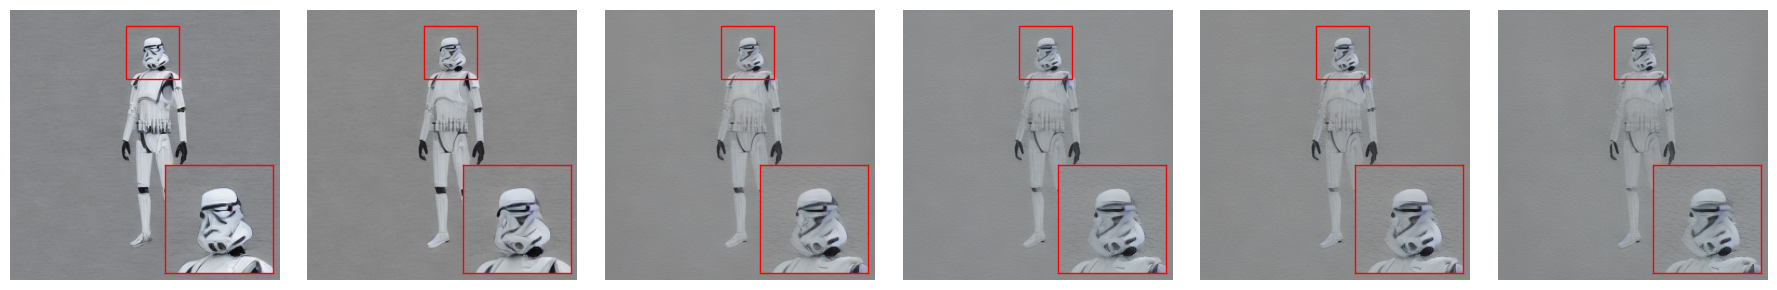

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.transforms import Bbox
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.matplotlib_utils import add_zoom_inset


row = data[:, 0]

frame_index = 0
frames = [d.vid_frames[frame_index] for d in row]

fig, axs = display_ims(frames, show=False)

for ax in axs:
    box = Bbox.from_bounds(220, 30, 100, 100)
    add_zoom_inset(ax, box)

plt.savefig('outs/stormtrooper_num_keyframes_quality.pdf', dpi=300, bbox_inches='tight')

In [72]:
d = data[0, 3]

display_vid(pil_frames_to_clip(d.vid_frames))

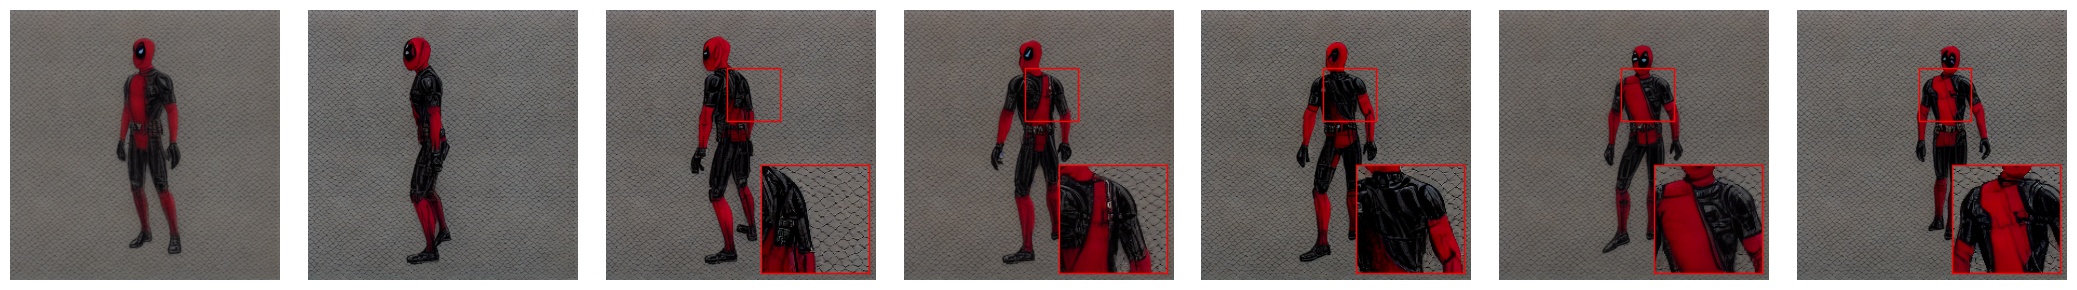

In [158]:
from matplotlib import pyplot as plt
from matplotlib.transforms import Bbox
import numpy as np
from text3d2video.util import ordered_sample_indices
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.matplotlib_utils import add_zoom_inset, bbox_around_point

frame_indices = ordered_sample_indices(d.vid_frames, 7)
frame_indices = [4, 10, 13, 15, 16, 17, 19]
gr_frames = [d.vid_frames[i] for i in frame_indices]

fig, axs = display_ims(gr_frames, show=False)

for i, ax in enumerate(axs):
    center = np.array([280, 160])
    box = bbox_around_point(center, 100)
    if i >= 2:
        add_zoom_inset(ax, box, color='red')

plt.savefig("outs/180_deadpool_content_drift.pdf", dpi=300, bbox_inches="tight")